In [1]:
require(rjags)

Loading required package: rjags
Loading required package: coda
Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


#### Again, we premake the .j model file

model{
	#priors for discriminability and bias
	d ~ dnorm(1,1)
	b ~ dnorm(0,1)
	
	#express as areas under the curve
	phih = phi(d/2-b) #normal cdf
	phif = phi(-d/2-b)
	
	#observed hits and false alarms
	h ~ dbin(phih,sigtrials)
	f ~ dbin(phif,noistrials)
}

So what's happening here:
- we have a difference between distributions that is thought to be normally distributed around 1 with std of 1
- we have a decision bound that is thought to be normally distributed around 0 with std of 1

__Next__
We calculate the area under the curve for the areas that correspond to hits and misses

__Then__
we tell the program that these values are binomially distributed random variables

In [2]:
setwd("~/Documents/lmb/chapt8")

#provide data
h = 60
f = 11
sigtrials = noistrials = 100

#initialize for JAGS
oneinit = list(d=0,b=0) #initialize values for MCMC chain
myinits = list(oneinit)[rep(1,4)]
#Initialize the params with some added noise
myinits = lapply(myinits, FUN=function(x) lapply(x,FUN=function(y) y+rnorm(1,0,.1)))
                                                  
sdtj = jags.model("sdt_model.j",data=list("h"=h,"f"=f, "sigtrials"=sigtrials, "noistrials"=noistrials),
                 inits=myinits, n.chains=4)

                                                  
#Burnin
update(sdtj,n.iter=1000)

#perform MCMC
parameters=c("d","b","phih","phif")
mcmcfin=coda.samples(sdtj,parameters,5000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 2
   Total graph size: 16

Initializing model



In [3]:
myinits

[[1]]
[[1]]$d
[1] -0.02929745

[[1]]$b
[1] 0.1359122


[[2]]
[[2]]$d
[1] -0.09158166

[[2]]$b
[1] -0.001367488


[[3]]
[[3]]$d
[1] -0.00976704

[[3]]$b
[1] -0.04150429


[[4]]
[[4]]$d
[1] -0.04412517

[[4]]$b
[1] -0.1277186

In [9]:
summary(mcmcfin)


Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD  Naive SE Time-series SE
b    0.4825 0.10385 0.0007343      0.0010274
d    1.4623 0.20324 0.0014372      0.0019520
phif 0.1155 0.03137 0.0002218      0.0003280
phih 0.5975 0.04794 0.0003390      0.0003862

2. Quantiles for each variable:

        2.5%     25%    50%    75%  97.5%
b    0.27965 0.41189 0.4816 0.5529 0.6862
d    1.07035 1.32327 1.4612 1.5982 1.8667
phif 0.06215 0.09298 0.1132 0.1350 0.1834
phih 0.50083 0.56494 0.5987 0.6301 0.6889


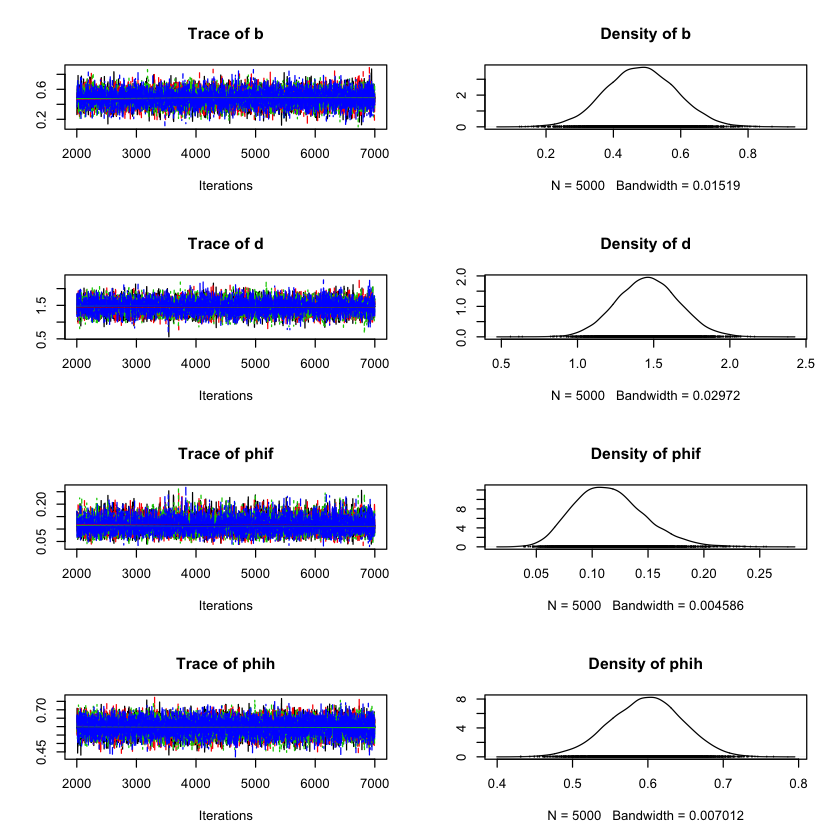

In [10]:
plot(mcmcfin)

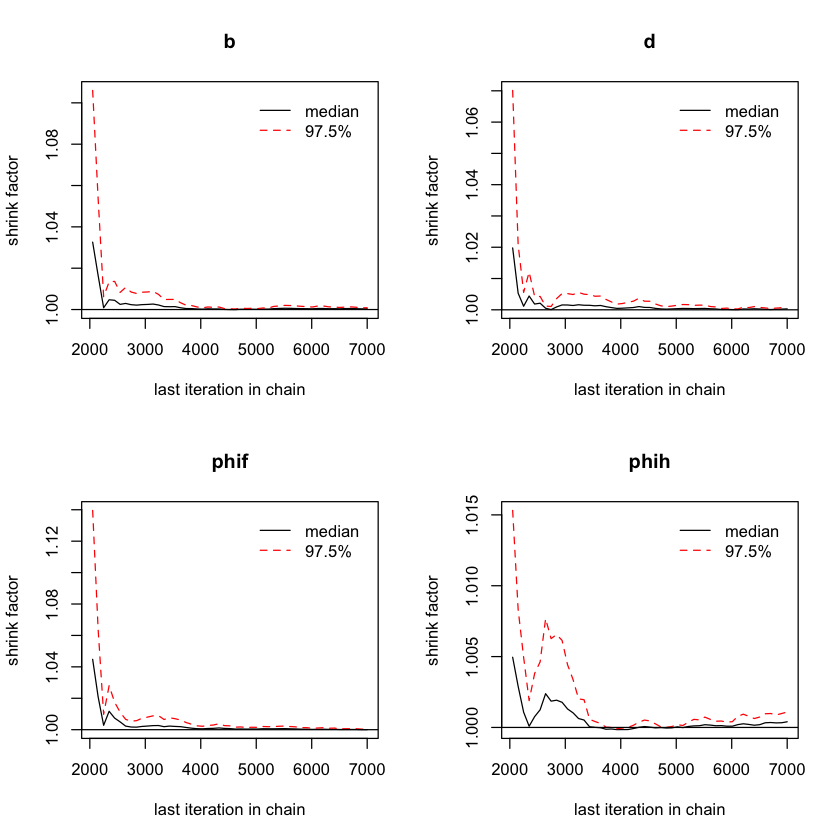

In [11]:
gelman.plot(mcmcfin)

#### Gelman plots
The chains should become indistinguishable.
The Gelman analysis estimates convergence as a ratio of variances in the within-group (or within-chain) and between-group (between chain). That ratio should drop to 1.

# Multinomial Processing Trees (MPTs)

Applies to categorical data with well-defined response categories

#### One-high threshold old model
Two params
    1) probability of being in the "certain that an item is old" state
    2) probability of guessing "old" when in a state of uncertainty
    
Model:
    - p(hit) = $\theta_1$ + (1- $\theta_1)\theta_2$
    - p(FA) = $\theta_2$
    
<img src='ht_model.png'>



- c = $\theta_1$
- 1-c = $\theta_2$

Basically, there is some param ($\theta_1$) that we are in a certain state.  Within uncertain states, there is some param that describes our propensity to guess "old" ($\theta_2$)

There's also new items and we guess old with some prob or dont with 1-that prob

#### High threshold model
model{
	#priors for MPT params (uniform rather than normal)
	th1 ~ dbeta(1,1)
	th2 ~ dbeta(1,1)
	
	#predictions for responses
    #probability of a hit is combination of certain recollection and uncertain but still guess old. This is different from previous models where we computed these values from a normal distribution.
	predh = th1+(1-th1)*th2
    #Probability of a false alarm is just the probabilty of guessing old when something is new
	predf = th2
	
	#Observed responses
    #Again, we wnat this to be a bimodial distribution
	h ~ dbin(predh,sigtrials)
	f ~ dbin(predf,noistrials)
}

In [22]:
### Now for this new model
#Provide the data
h = 60
f = 11
sigtrials = noistrials = 100

#define the JAGS model
oneht=jags.model("1ht.j", data=list("h"=h,"f"=f,"sigtrials"=sigtrials,"noistrials"=noistrials),
                n.chains=4)

#burnin
update(oneht,n.iter=1000)

#Perform MCMC
parameters = c("th1","th2","predh","predf")
mcmcfin = coda.samples(oneht, parameters,5000)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 2
   Total graph size: 10

Initializing model



In [23]:
summary(mcmcfin)


Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
predf 0.1186 0.03190 0.0002256      0.0003296
predh 0.5976 0.04786 0.0003384      0.0004255
th1   0.5429 0.05699 0.0004030      0.0005581
th2   0.1186 0.03190 0.0002256      0.0003296

2. Quantiles for each variable:

         2.5%     25%    50%    75%  97.5%
predf 0.06388 0.09582 0.1160 0.1383 0.1882
predh 0.50241 0.56546 0.5982 0.6305 0.6908
th1   0.42914 0.50494 0.5439 0.5822 0.6512
th2   0.06388 0.09582 0.1160 0.1383 0.1882


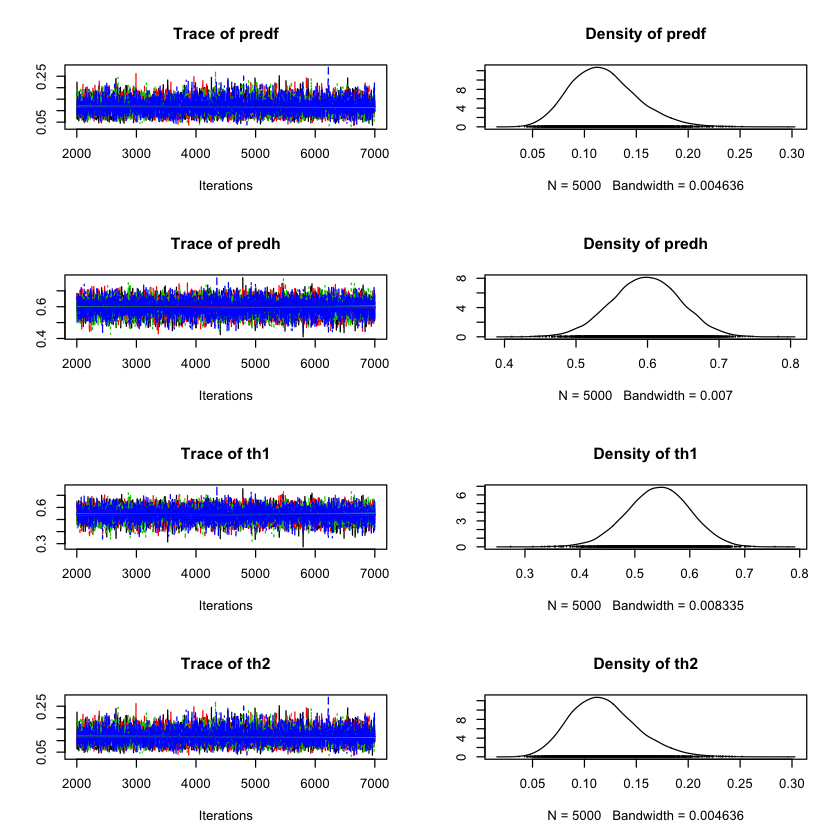

In [24]:
plot(mcmcfin)

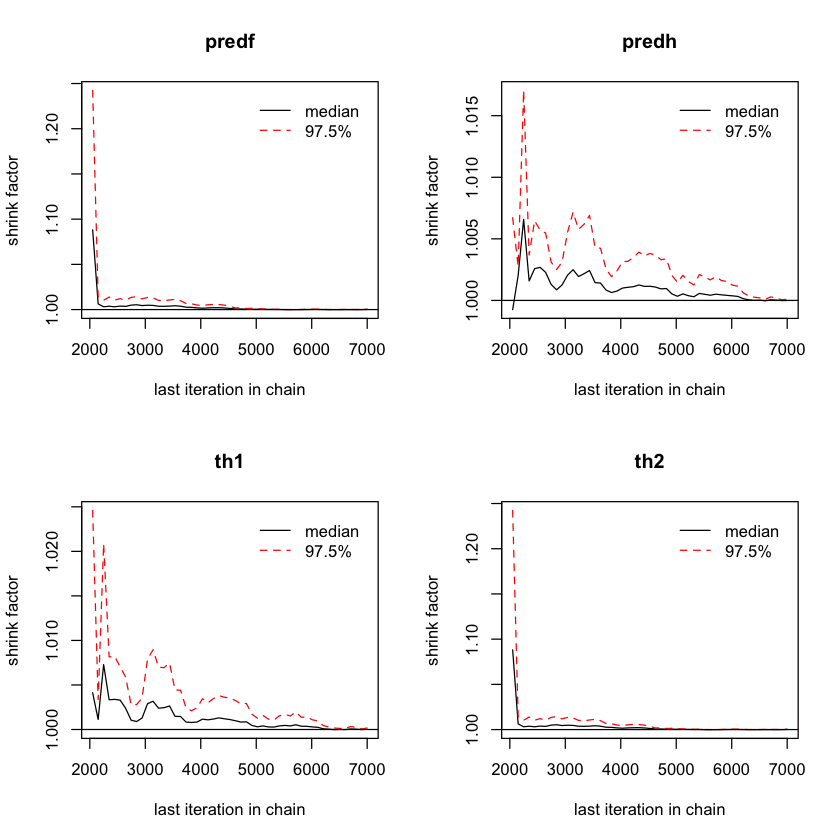

In [25]:
gelman.plot(mcmcfin)

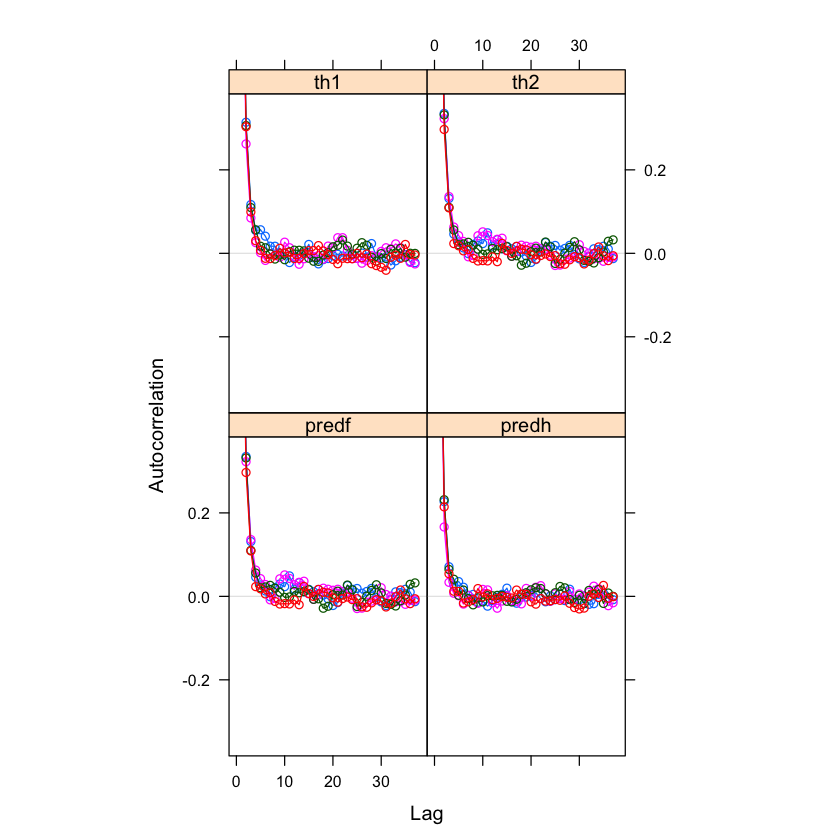

In [26]:
# Check for autocorrelations
acfplot(mcmcfin)

In [27]:
mcmcthin = coda.samples(oneht, parameters,5000,thin=4)

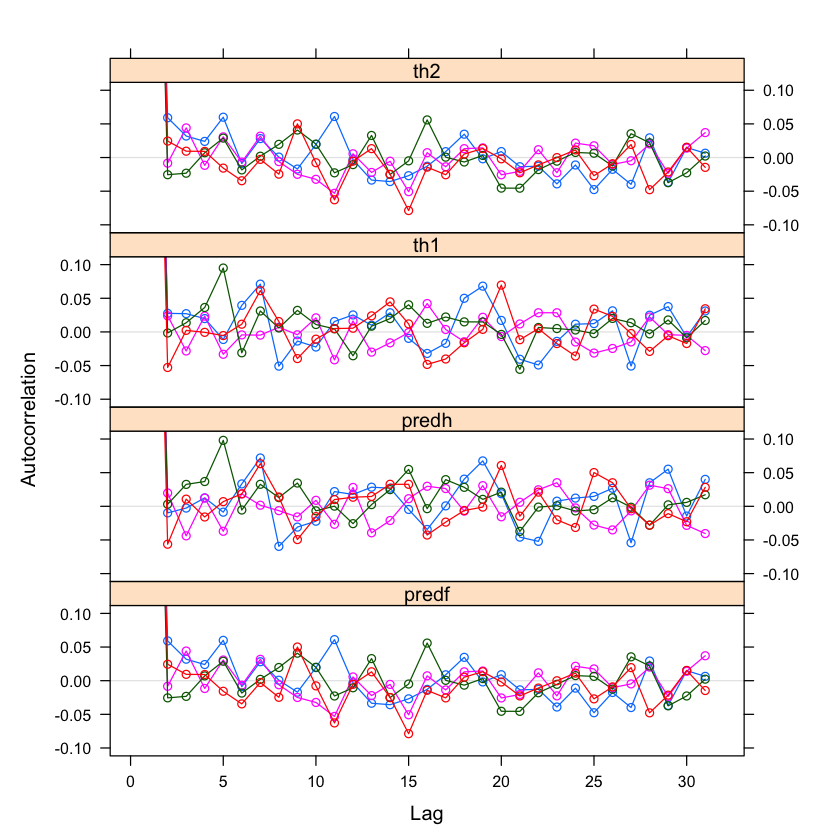

In [28]:
acfplot(mcmcthin)

# Witness Reliability Modelling
<img src="witnessExample.png">

<img src="noConflictMod.png">

__Notes:__
Using this tree diagram, we can predict the probabilities of participants remembering one thing but not the other etc... This isn't going to be pretty but we can easily model this complex set of conditionals

<img src="table4.png">

#Big old model
model {
	#Priors: all are uniform
	p ~ dbeta(1,1)
	q ~ dbeta(1,1)
	c ~ dbeta(1,1)
	
	#Data: multinomial as a function of predicted probabilites
	consistent[1:4] ~ dmulti(predprob[1,1:4],Nsubj[1])
	inconsistent[1:4] ~ dmulti(predprob[2,1:4],Nsubj[2])
	neutral[1:4] ~ dmulti(predprob[3,1:4],Nsubj[3])
	
	#Predictions for all three conditions
	#Row numbers rever to Table X.1
	
	#Consistent Condition
	predprob[1,1] = (1+p+q - p*q + 4 * p*c)/6 #row 1
	predprob[1,2] = (1 + p+q-p*q-2*p*c)/3 #row 2
	predprob[1,3] = (1 - p - q + p*q)/6 #row 3
	predprob[1,4] = (1 - p - q + p*q)/3 #row 4
	
	#Inconsistent condition
	predprob[2,1] = (1+p-q+p*q+4*p*c)/6 #row 5
	predprob[2,2] = (1 + p -q + p*q -2 * p*c)/3 #row 6
	predprob[2,3] = (1-p+q-p*q)/6 #row 7
	predprob[2,4] = (1-p+q-p*q)/3 #row 8
	
	#Neutral condition
	predprob[3,1] = (1+p+4*p*c)/6 #row 9
	predprob[3,2] = (1+p-2*p*c)/3 #row 10
	predprob[3,3] = (1-p)/6 #row 11
	predprob[3,4] = (1-p)/3 #row 12
}

In [30]:
#Run the model

#initialize the data
consistent = c(78,70,7,15)
inconsistent = c(102,55,40,53)
neutral = c(63,45,13,21)
Nsubj =c(170,250,142)

#Define that JAGS
noconflict = jags.model("memMod.j",data=list("Nsubj"=Nsubj,"consistent"=consistent,
                                            "inconsistent"=inconsistent,"neutral"=neutral),
                       n.chains=3)

#burnin
update(noconflict,n.iter=1000)

#perform MCMC
parms4j=c("p","q","c","predprob")
mcmcfin=coda.samples(noconflict,parms4j,5000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 3
   Unobserved stochastic nodes: 3
   Total graph size: 48

Initializing model



In [31]:
summary(mcmcfin)


Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                 Mean       SD  Naive SE Time-series SE
c             0.56852 0.058288 4.759e-04      7.798e-04
p             0.49852 0.034914 2.851e-04      4.632e-04
predprob[1,1] 0.47880 0.020364 1.663e-04      1.870e-04
predprob[2,1] 0.39742 0.022425 1.831e-04      1.971e-04
predprob[3,1] 0.43811 0.020462 1.671e-04      1.801e-04
predprob[1,2] 0.39252 0.022844 1.865e-04      2.793e-04
predprob[2,2] 0.22977 0.022173 1.810e-04      2.539e-04
predprob[3,2] 0.31115 0.018613 1.520e-04      2.398e-04
predprob[1,3] 0.04289 0.007858 6.416e-05      1.031e-04
predprob[2,3] 0.12427 0.009280 7.577e-05      9.461e-05
predprob[3,3] 0.08358 0.005819 4.751e-05      7.720e-05
predprob[1,4] 0.08578 0.015717 1.283e-04      2.061e-04
predprob[2,4] 0.24854 0.018560 1.515e-04      1.892e-04
predprob[3,4] 0.167

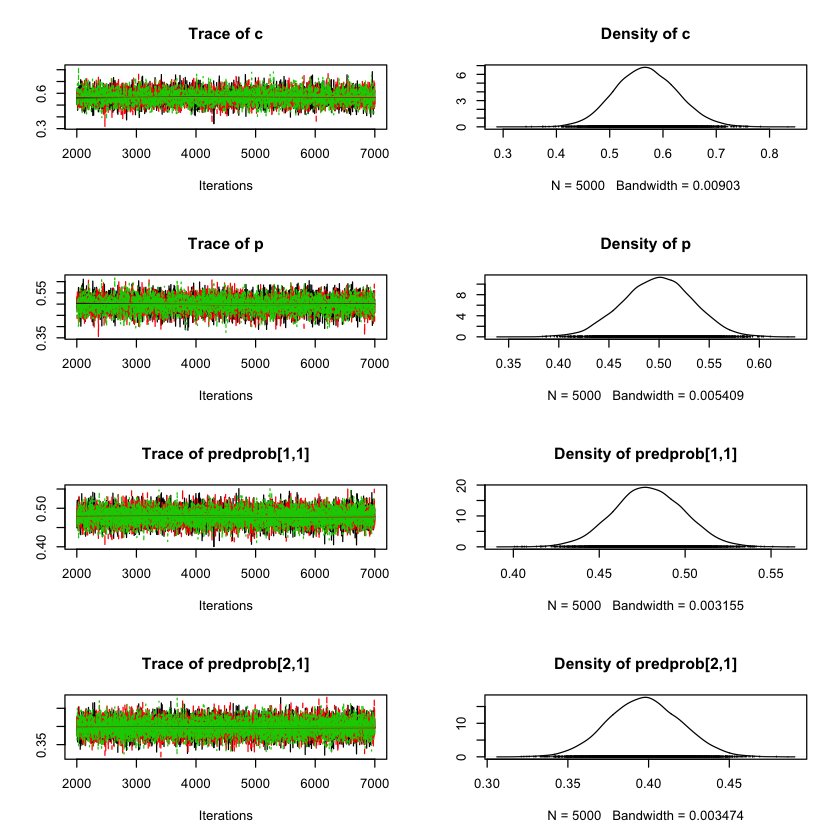

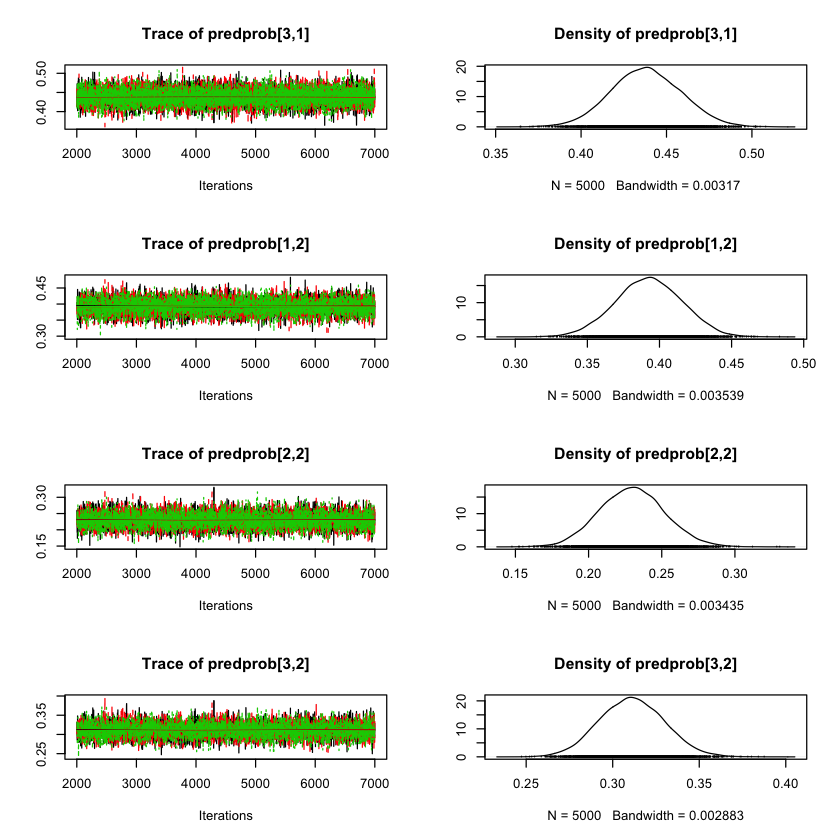

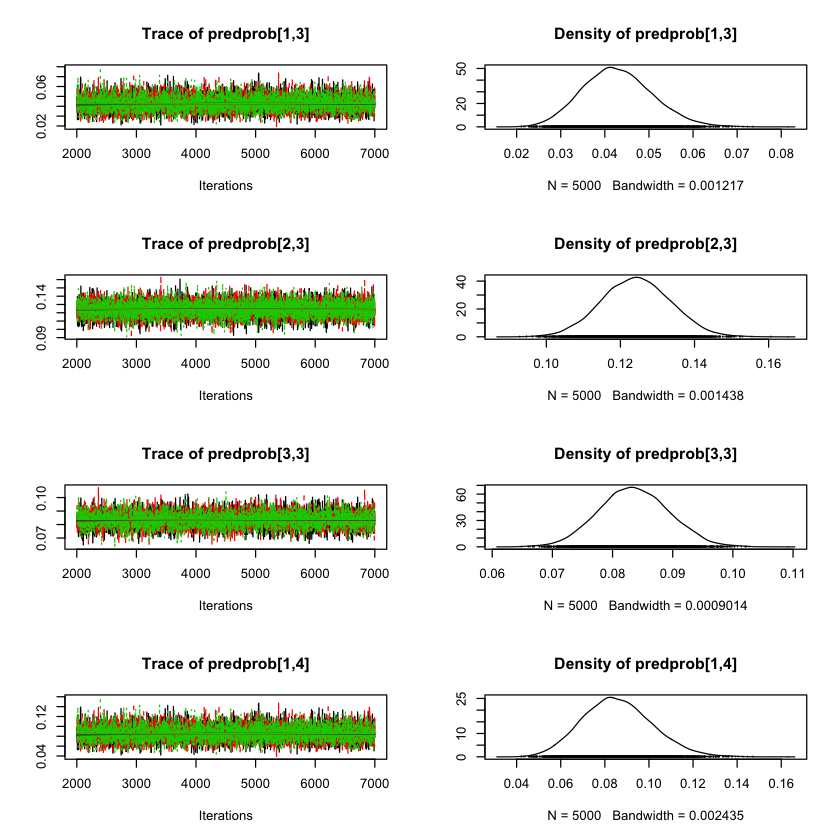

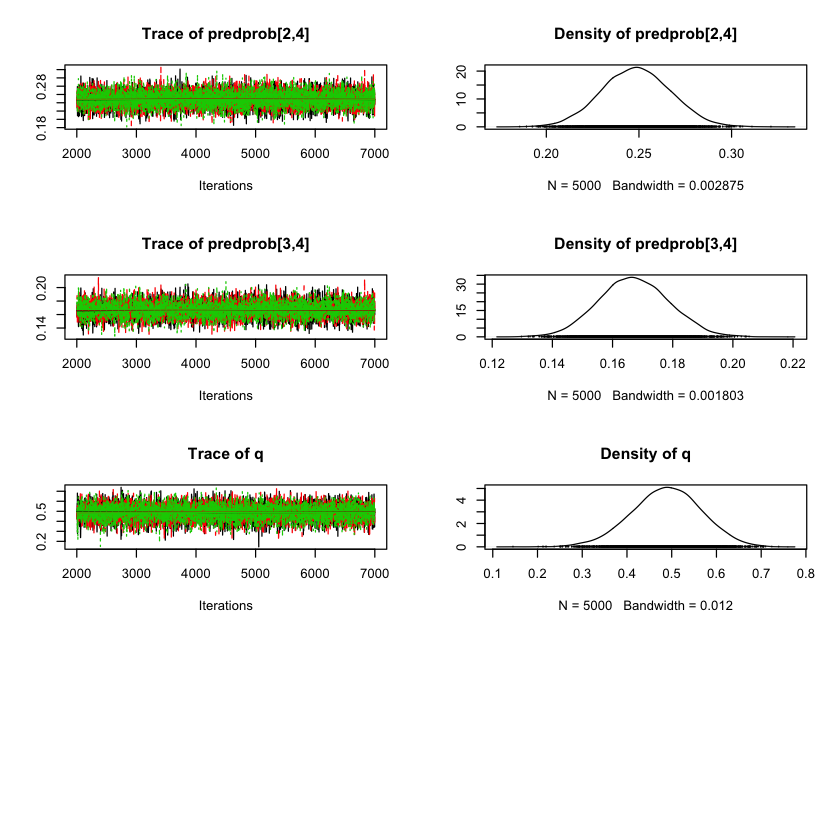

In [32]:
plot(mcmcfin)

In [33]:
#Was memory above chance?
allpost = function(mcmcfin,pn){
    return (unlist(lapply(mcmcfin,FUN=function(x) c(x[,pn]))))
}
                          
mean(allpost(mcmcfin,"c")>.5)
mean(allpost(mcmcfin,"p")>.5)
mean(allpost(mcmcfin,"q")>.5)

[1] 0.8815333

[1] 0.4910667

[1] 0.4478667

# Summary (in vivo)

1) Run MCMC to achieve effective sample size (ESS) of 10,000
    - Long chains are not necessary for relatively stable things like median
    - However, really important for estimating parameter distribution width
    - 10000 independent samples is a good number
        - However, chains are strongly autocorrelated

In [34]:
effectiveSize(mcmcfin)

c             p predprob[1,1] predprob[2,1] predprob[3,1] 
     5618.421      5693.695     11886.228     12951.247     12926.128 
predprob[1,2] predprob[2,2] predprob[3,2] predprob[1,3] predprob[2,3] 
     6777.462      7644.360      6063.093      5862.156      9643.612 
predprob[3,3] predprob[1,4] predprob[2,4] predprob[3,4]             q 
     5693.695      5862.156      9643.612      5693.695      8076.064

2) Compose JAGS model statements for human readability
    - Specify models by first describing how data are probabilistically distributed by some likelihood function
    - then specifiy the parameters of that likelihood function

3) Make some diagrams to make information digestable.
<img src="normMod.png">